In [1]:
%load_ext autoreload
%autoreload 2
import os
from model import get_yolov8_obb_model
import shutil
import numpy as np

Определение параметров обучения

In [3]:
DATASET_YAML = "dataset.yaml"
EPOCHS = 5
IMG_SIZE = 640
BATCH_SIZE = 16
MODEL_SIZE = "n"
PROJECT_NAME = "yolov8-obb-sroie"

Обучение модели

In [4]:
# Загружаем модель
model = get_yolov8_obb_model(model_size=MODEL_SIZE)

# Обучаем
results = model.train(
    data=DATASET_YAML,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name=PROJECT_NAME,
    plots=True,
    save=True,
    exist_ok=True
)

Ultralytics 8.3.237  Python-3.8.8 torch-2.4.1+cpu CPU (11th Gen Intel Core i5-1135G7 @ 2.40GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-obb.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8-obb-sroie, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

In [5]:
print("mAP50:", results.results_dict['metrics/mAP50(B)'])
print("mAP50-95:", results.results_dict['metrics/mAP50-95(B)'])

mAP50: 0.937794437697812
mAP50-95: 0.699630355361924


In [34]:
model = get_yolov8_obb_model(weights_path="best_model.pt")

# Обучаем
results_add = model.train(
    data=DATASET_YAML,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name=PROJECT_NAME,
    plots=True,
    save=True,
    exist_ok=True
)

Ultralytics 8.3.237  Python-3.8.8 torch-2.4.1+cpu CPU (11th Gen Intel Core i5-1135G7 @ 2.40GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=best_model.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8-obb-sroie, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True

In [36]:
print("mAP50:", results_add.results_dict['metrics/mAP50(B)'])
print("mAP50-95:", results_add.results_dict['metrics/mAP50-95(B)'])

mAP50: 0.9629526241526215
mAP50-95: 0.7558813383948844


Сохранениее весов лучшей модели

In [37]:
best_weight_path = f"runs/obb/{PROJECT_NAME}/weights/best.pt"
output_path = "best_model.pt"

shutil.copy(best_weight_path, output_path)
print(f"Лучшие веса сохранены в: {output_path}")

Лучшие веса сохранены в: best_model.pt


Проверка на валидации

In [7]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
from task1_utils.metrics import compute_f1_score
import cv2

In [38]:
model = get_yolov8_obb_model(weights_path="best_model.pt")

VAL_IMG_DIR = "yolo_obb_dataset/images/val"
VAL_LABEL_DIR = "yolo_obb_dataset/labels/val"

val_images = [f for f in os.listdir(VAL_IMG_DIR) if f.lower().endswith(('.jpg', '.png'))]

all_predictions = []
all_ground_truths = []

for img_name in val_images:
    img_path = os.path.join(VAL_IMG_DIR, img_name)
    label_path = os.path.join(VAL_LABEL_DIR, Path(img_name).with_suffix('.txt'))

    results = model.predict(source=img_path, conf=0.5, verbose=False)
    
    pred_polys = []
    if results[0].obb is not None:
        obb_tensor = results[0].obb.xyxyxyxy
        if obb_tensor is not None:
            for poly in obb_tensor.cpu().numpy():
                pred_polys.append(poly.reshape(-1).astype(np.float32))

    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    gt_polys = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 9:
                    coords_norm = list(map(float, parts[1:]))
                    coords_abs = []
                    for i, c in enumerate(coords_norm):
                        coords_abs.append(c * (w if i % 2 == 0 else h))
                    gt_polys.append(np.array(coords_abs, dtype=np.float32))
    
    all_predictions.append(pred_polys)
    all_ground_truths.append(gt_polys)


In [39]:
f1 = compute_f1_score(all_predictions, all_ground_truths, iou_threshold=0.5)
print(f"F1-score на валидации: {f1:.4f}")

F1-score на валидации: 0.9017


Визуализация

In [40]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

In [44]:
all_files = [f for f in os.listdir(VAL_IMG_DIR) if f.endswith('.jpg')]
EXAMPLES = random.sample(all_files, 3)

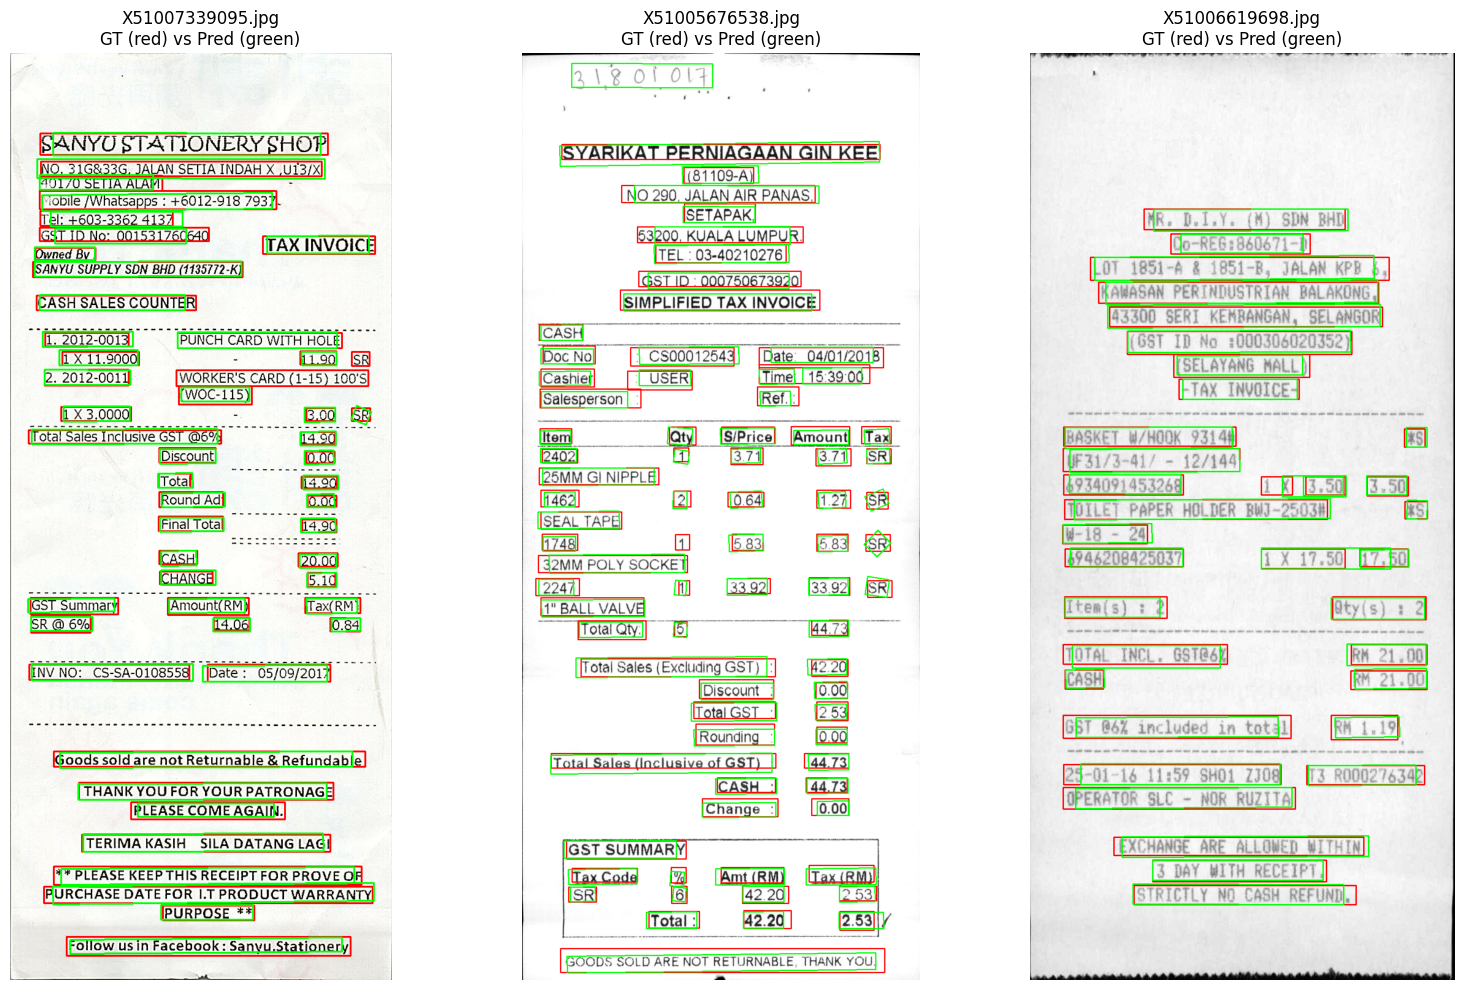

In [45]:
# --- Вспомогательная функция: рисовать полигоны ---
def draw_obb(image, polys, color=(0, 255, 0), thickness=2):
    """Рисует ориентированные bounding boxes (полигоны из 4 точек)."""
    for poly in polys:
        pts = np.array(poly, dtype=np.int32).reshape((-1, 1, 2))
        cv2.polylines(image, [pts], isClosed=True, color=color, thickness=thickness)
    return image

# --- Обработка примеров ---
plt.figure(figsize=(16, 10))
for i, img_name in enumerate(EXAMPLES, 1):
    img_path = os.path.join(VAL_IMG_DIR, img_name)
    lbl_path = os.path.join(VAL_LABEL_DIR, Path(img_name).with_suffix('.txt'))
    
    if not os.path.exists(img_path):
        print(f" Файл не найден: {img_path}")
        continue

    # Загружаем изображение
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Предсказание
    results = model.predict(source=img_path, conf=0.5, verbose=False)
    pred_polys = []
    if results[0].obb is not None:
        obb_tensor = results[0].obb.xyxyxyxy  # [N, 8]
        if obb_tensor is not None:
            pred_polys = [poly.cpu().numpy() for poly in obb_tensor]

    # Загружаем GT (денормализуем)
    gt_polys = []
    if os.path.exists(lbl_path):
        with open(lbl_path, 'r', encoding='latin1') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 9:
                    coords_norm = list(map(float, parts[1:]))
                    coords_abs = [
                        coords_norm[i] * (w if i % 2 == 0 else h)
                        for i in range(8)
                    ]
                    gt_polys.append(coords_abs)

    # Рисуем GT (красный) и Pred (зелёный)
    vis_img = img.copy()
    vis_img = draw_obb(vis_img, gt_polys, color=(255, 0, 0), thickness=2)      # GT — красный
    vis_img = draw_obb(vis_img, pred_polys, color=(0, 255, 0), thickness=2)    # Pred — зелёный

    # Показываем
    plt.subplot(1, len(EXAMPLES), i)
    plt.imshow(vis_img)
    plt.title(f"{img_name}\nGT (red) vs Pred (green)")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [46]:
model = get_yolov8_obb_model(weights_path="best_model.pt")
model.predict("yolo_obb_dataset/images/test", save=True)


image 1/347 c:\Users\Lisa\Documents\Study\deep_arch\NN-Architectures-Project\Task1\RectYoloV8\yolo_obb_dataset\images\test\X00016469670.jpg: 640x352 49 words, 42.5ms
image 2/347 c:\Users\Lisa\Documents\Study\deep_arch\NN-Architectures-Project\Task1\RectYoloV8\yolo_obb_dataset\images\test\X00016469671.jpg: 640x384 41 words, 45.5ms
image 3/347 c:\Users\Lisa\Documents\Study\deep_arch\NN-Architectures-Project\Task1\RectYoloV8\yolo_obb_dataset\images\test\X51005200931.jpg: 640x480 90 words, 53.9ms
image 4/347 c:\Users\Lisa\Documents\Study\deep_arch\NN-Architectures-Project\Task1\RectYoloV8\yolo_obb_dataset\images\test\X51005230605.jpg: 640x320 42 words, 41.7ms
image 5/347 c:\Users\Lisa\Documents\Study\deep_arch\NN-Architectures-Project\Task1\RectYoloV8\yolo_obb_dataset\images\test\X51005230616.jpg: 640x224 50 words, 31.6ms
image 6/347 c:\Users\Lisa\Documents\Study\deep_arch\NN-Architectures-Project\Task1\RectYoloV8\yolo_obb_dataset\images\test\X51005230621.jpg: 640x224 54 words, 31.9ms
ima

[ultralytics.engine.results.Results object with attributes:
 
 boxes: None
 keypoints: None
 masks: None
 names: {0: 'word'}
 obb: ultralytics.engine.results.OBB object
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[237, 237, 237],
         [238, 238, 238],
         [255, 255, 255],
         ...,
         [238, 238, 238],
         [251, 251, 251],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [239, 239, 239],
         [239, 239, 239],
         ...,
         [255, 255, 25